# Megaline Prepaid Plans Profitabillity

## 1. Open the data file and study the general information.

In [6]:
import pandas as pd
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
tariffs = pd.read_csv('/datasets/megaline_tariffs.csv')
users = pd.read_csv('/datasets/megaline_users.csv')
print('Calls')
print('-----')
print(calls.info(), calls.describe())
print('-----------------------------------')
print('Internet')
print('--------')
print(internet.info(), internet.describe())
print('-----------------------------------')
print('Messages')
print('--------')
print(messages.info(), messages.describe())
print('-----------------------------------')
print('Tarrifs')
print('-------')
print(tariffs.info(), tariffs.describe())
print('-----------------------------------')
print('Users')
print('-----')
print(users.info(), users.describe())


Calls
-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None              user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000
-----------------------------------
Internet
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int

I opened each table and assigned the dataframes to variables, and then printed the info and data description for each to identify any data that needs to be fixed in preprocessing.

## 2. Prepare the data.

In [7]:

messages['message_count'] = 1
total_use = calls.append([internet, messages], sort=True)
total_use = total_use.fillna(0)
total_use['call_date'] = pd.to_datetime(total_use['call_date'])
total_use['session_date'] = pd.to_datetime(total_use['session_date'])
total_use['message_date'] = pd.to_datetime(total_use['message_date'])
total_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318611 entries, 0 to 76050
Data columns (total 8 columns):
call_date        318611 non-null datetime64[ns]
duration         318611 non-null float64
id               318611 non-null object
mb_used          318611 non-null float64
message_count    318611 non-null float64
message_date     318611 non-null datetime64[ns]
session_date     318611 non-null datetime64[ns]
user_id          318611 non-null int64
dtypes: datetime64[ns](3), float64(3), int64(1), object(1)
memory usage: 21.9+ MB


I combined the dataframes into one master dataframe to better calculate. I added a message counter column to keep a count of messages sent before i combined the data frame and filled NA values. I filled all NA values with zero so that the data for users who were missing data in calls, messages, or internet could still be included in the final calculations. I then converted the date columns to date time so that I could sort by month.

In [8]:

import numpy as np
total_use['duration'] = np.ceil(total_use['duration'])
total_use['call_date'] = pd.to_datetime(total_use['call_date']) 
total_use['call_month'] = total_use['call_date'].dt.month
calls_per_month = total_use.pivot_table(index=['user_id', 'call_month'], values=['duration'], aggfunc=np.sum)
avg_calls_per_month = calls_per_month.groupby('user_id').mean()
print(avg_calls_per_month)
total_use['mb_used'] = np.ceil(total_use['mb_used'])
total_use['session_date'] = pd.to_datetime(total_use['session_date'])
total_use['int_month'] = total_use['session_date'].dt.month
internet_per_month = total_use.pivot_table(index=['user_id', 'int_month'], values=['mb_used'], aggfunc=np.sum)
avg_internet_per_month = internet_per_month.groupby('user_id').mean()
print(avg_internet_per_month)
total_use['msg_month'] = total_use['message_date'].dt.month
messages_per_month = total_use.pivot_table(index=['user_id', 'msg_month'], values=['message_count'], aggfunc=np.sum)
avg_messages_per_month = messages_per_month.groupby('user_id').mean()
print(avg_messages_per_month)

           duration
user_id            
1000      62.000000
1001     288.000000
1002     207.250000
1003     552.000000
1004     308.000000
...             ...
1495     353.000000
1496     242.500000
1497     150.000000
1498     267.583333
1499     307.000000

[490 rows x 1 columns]
              mb_used
user_id              
1000       951.500000
1001     13423.333333
1002     10084.750000
1003     13534.500000
1004     17394.222222
...               ...
1495     19802.000000
1496     10726.166667
1497      5560.000000
1498     18983.166667
1499     14288.800000

[490 rows x 1 columns]
         message_count
user_id               
1000          5.500000
1001         34.500000
1002         22.000000
1003         25.000000
1004         19.666667
...                ...
1495          0.000000
1496         10.833333
1497         25.000000
1498          0.000000
1499          0.000000

[490 rows x 1 columns]


For the Calls, Messages, and Internet tables i converted the date columns to date time so i could then use the .dt.month method to create a column contain the month each call, session, or message was made. I also added a column of 1 to the messages table so that could count messages Then I created a pivot table for each and used the user id and month as the index and passed the aggfunc parameter as sum so now i have a data frame that has to user id and the usage for each month. Then i can use the groupby method to find the average monthly usage for each user.

In [9]:

extra_users = list(set(users['user_id']) - set(total_use['user_id'].unique()))
extra_users

[1025, 1378, 1463, 1473, 1319, 1129, 1307, 1269, 1143, 1275]

In the previous step i found that there were 10 users that did not have data for calls, messages, or text. using the set() and list() method i identified these user id's and put them in a list.

In [10]:

users = users.drop([25, 378, 463, 473, 319, 129, 307, 269, 143, 275])
users['avg_calls_per_month'] = avg_calls_per_month['duration'].to_numpy()
users['avg_internet_per_month'] = avg_internet_per_month['mb_used'].to_numpy()
users['avg_messages_per_month'] = avg_messages_per_month['message_count'].to_numpy()
users

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date,avg_calls_per_month,avg_internet_per_month,avg_messages_per_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,62.000000,951.500000,5.500000
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,288.000000,13423.333333,34.500000
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,207.250000,10084.750000,22.000000
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,552.000000,13534.500000,25.000000
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,308.000000,17394.222222,19.666667
...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,353.000000,19802.000000,0.000000
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,242.500000,10726.166667,10.833333
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN,150.000000,5560.000000,25.000000
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN,267.583333,18983.166667,0.000000


I used the list created in the previous step to remove the users with no data, because i wont be able to calculate and profit for these users with no data availible. Then i added the average usage data for each user that i calculated in the pivot tables above.

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,tariff_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [12]:
surf_users = users.query('tariff == "surf"').copy()
def calc_surf_call_overage(row):
    calls = row['avg_calls_per_month'] - 500
    
    if calls < 0:
        return 0
    if calls > 0:
        return calls
    
def calc_surf_mb_overage(row):
    mb = row['avg_internet_per_month'] - 15360
    
    if mb < 0:
        return 0
    if mb > 0:
        return mb

def calc_surf_message_overage(row):
    messages = row['avg_messages_per_month'] - 50
    
    if messages < 0:
        return 0
    if messages > 0:
        return messages
    
surf_users['call_overage_per_user'] = surf_users.apply(calc_surf_call_overage, axis=1)
surf_users['mb_overage_per_user'] = surf_users.apply(calc_surf_mb_overage, axis=1)
surf_users['message_overage_per_user'] = surf_users.apply(calc_surf_message_overage, axis=1)
surf_users['profit_per_user'] = round((surf_users['call_overage_per_user'] * 0.03) + ((surf_users['mb_overage_per_user']/1000) * 10) + (surf_users['message_overage_per_user'] * 0.03) + 20, 2)
surf_users.head(10)

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date,avg_calls_per_month,avg_internet_per_month,avg_messages_per_month,call_overage_per_user,mb_overage_per_user,message_overage_per_user,profit_per_user
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,288.000000,13423.333333,34.500000,0.000000,0.000000,0.0,20.00
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,207.250000,10084.750000,22.000000,0.000000,0.000000,0.0,20.00
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,552.000000,13534.500000,25.000000,52.000000,0.000000,0.0,21.56
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,308.000000,17394.222222,19.666667,0.000000,2034.222222,0.0,40.34
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN,248.000000,8582.000000,5.500000,0.000000,0.000000,0.0,20.00
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN,440.166667,23996.500000,42.500000,0.000000,8636.500000,0.0,106.36
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN,661.555556,20823.666667,0.000000,161.555556,5463.666667,0.0,79.48
10,1010,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,NaN,507.500000,13751.500000,0.000000,7.500000,0.000000,0.0,20.23
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,51.000000,8613.666667,0.000000,0.000000,0.000000,0.0,20.00
14,1014,Edmundo,Simon,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-25,surf,NaN,425.666667,2993.000000,24.333333,0.000000,0.000000,0.0,20.00


In [13]:
ultimate_users = users.query('tariff == "ultimate"').copy()
def calc_ultimate_call_overage(row):
    calls = row['avg_calls_per_month'] - 3000
    
    if calls < 0:
        return 0
    if calls > 0:
        return calls
    
def calc_ultimate_mb_overage(row):
    mb = row['avg_internet_per_month'] - 30720
    
    if mb < 0:
        return 0
    if mb > 0:
        return mb
    
def calc_ultimate_message_overage(row):
    message = row['avg_messages_per_month'] - 1000
    
    if message < 0:
        return 0
    if message > 0:
        return message
    
ultimate_users['call_overage_per_user'] = ultimate_users.apply(calc_ultimate_call_overage, axis=1)
ultimate_users['mb_overage_per_user'] = ultimate_users.apply(calc_ultimate_mb_overage, axis=1)
ultimate_users['message_overage_per_user'] = ultimate_users.apply(calc_ultimate_message_overage, axis=1)
ultimate_users['profit_per_user'] = round((ultimate_users['call_overage_per_user'] * 0.01) + ((ultimate_users['mb_overage_per_user']/1000) * 7) + (ultimate_users['message_overage_per_user'] * 0.01) + 70, 2)
ultimate_users.head(10)

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date,avg_calls_per_month,avg_internet_per_month,avg_messages_per_month,call_overage_per_user,mb_overage_per_user,message_overage_per_user,profit_per_user
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,62.000000,951.500000,5.500000,0,0.000000,0,70.00
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,23.000000,11405.333333,51.333333,0,0.000000,0,70.00
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,389.000000,13886.000000,21.000000,0,0.000000,0,70.00
11,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN,363.375000,16493.875000,46.375000,0,0.000000,0,70.00
13,1013,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN,109.500000,10071.500000,8.000000,0,0.000000,0,70.00
26,1026,Meggan,Hamilton,49,"Houston-The Woodlands-Sugar Land, TX MSA",2018-07-20,ultimate,NaN,119.000000,4412.333333,7.333333,0,0.000000,0,70.00
28,1028,Jefferey,Rasmussen,57,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-02-21,ultimate,NaN,47.727273,32543.166667,63.000000,0,1823.166667,0,82.76
30,1030,Chase,Kane,30,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-02-14,ultimate,NaN,339.500000,10893.750000,7.500000,0,0.000000,0,70.00
31,1031,Lane,Martin,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-07-15,ultimate,NaN,421.000000,13284.857143,2.000000,0,0.000000,0,70.00
32,1032,Delila,Dalton,59,"Birmingham-Hoover, AL MSA",2018-06-07,ultimate,NaN,357.333333,9600.000000,14.000000,0,0.000000,0,70.00


I seperated the users based on which service plan they had. I defined functions to calculate the overages for each user and then created a column by calculating the profit from each user based off the service plan.

## 3. Analyse the data.

### Minutes

Average mintues used per month for Surf users ~ 317.1
Average mintues used per month for Ultimate users ~ 318.0
Variance for minutes for Surf users ~ 27379.284495565513
Variance for minutes for Ultimate users ~ 30434.42664604593
Standard deviation for minutes for Surf users ~ 165.46686827146246
Standard deviation for minutes for Ultimate users ~ 174.45465498531684


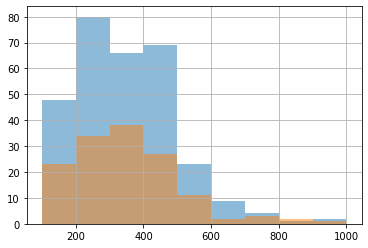

In [16]:
import matplotlib.pyplot as plt
print('Average mintues used per month for Surf users ~', round(surf_users['avg_calls_per_month'].mean(), 1))
print('Average mintues used per month for Ultimate users ~', round(ultimate_users['avg_calls_per_month'].mean(), 1))
print('Variance for minutes for Surf users ~', np.var(surf_users['avg_calls_per_month']))
print('Variance for minutes for Ultimate users ~', np.var(ultimate_users['avg_calls_per_month']))
print('Standard deviation for minutes for Surf users ~', np.std(surf_users['avg_calls_per_month']))
print('Standard deviation for minutes for Ultimate users ~', np.std(ultimate_users['avg_calls_per_month']))
surf_users['avg_calls_per_month'].hist(bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], alpha=0.5)
ultimate_users['avg_calls_per_month'].hist(bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], alpha=0.5)

For the average monthly minutes used found the the data is positively skewed. meaning even though there are vey few heavy users in terms of minutes, the majority of users sit below the 500 minute threshold for the surf plan. At 3 cents a minute a user with the surf plan could go 500 minutes over the monthly allowance and only incur an extra charge of 15 dollars.

### Internet

Average mb used per month for Surf users ~ 12381.0
Average mb used per month for Ultimate users ~ 12451.6
Variance for mb for Surf users ~ 30223750.72463463
Variance for mb for Ultimate users ~ 29488029.288344402
Standard deviation for mb for Surf users ~ 5497.613184340513
Standard deviation for mb for Ultimate users ~ 5430.288140452991


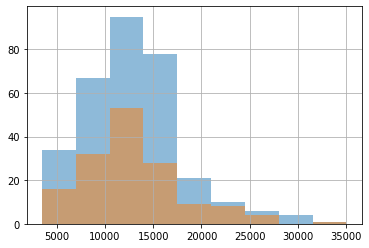

In [17]:
print('Average mb used per month for Surf users ~', round(surf_users['avg_internet_per_month'].mean(), 1))
print('Average mb used per month for Ultimate users ~', round(ultimate_users['avg_internet_per_month'].mean(), 1))
print('Variance for mb for Surf users ~', np.var(surf_users['avg_internet_per_month']))
print('Variance for mb for Ultimate users ~', np.var(ultimate_users['avg_internet_per_month']))
print('Standard deviation for mb for Surf users ~', np.std(surf_users['avg_internet_per_month']))
print('Standard deviation for mb for Ultimate users ~', np.std(ultimate_users['avg_internet_per_month']))
surf_users['avg_internet_per_month'].hist(bins=[3500, 7000, 10500, 14000, 17500, 21000, 24500, 28000, 31500, 35000], alpha=0.5)
ultimate_users['avg_internet_per_month'].hist(bins=[3500, 7000, 10500, 14000, 17500, 21000, 24500, 28000, 31500, 35000], alpha=0.5)

There is a simillar distribution for monthly internet use, and monthly minute use. However, at 10 dollars for every extra 1000 mb going even 5000 mb over the data allowance will result in a extra $50 charge for surf users. This represent a good percentage of the extra revenue made from overages.

### Messages

Average messages used per month for Surf users ~ 24.9
Average messages used per month for Ultimate users ~ 29.0
Variance for messages for Surf users ~ 591.5787605403347
Variance for messages for Ultimate users ~ 620.8354506606466
Standard deviation for messages for Surf users ~ 24.32239216319675
Standard deviation for messages for Ultimate users ~ 24.91656980125167


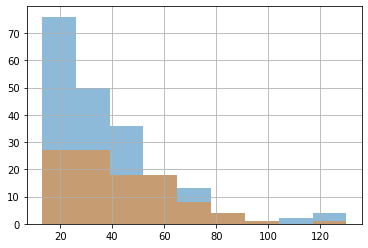

In [18]:
print('Average messages used per month for Surf users ~', round(surf_users['avg_messages_per_month'].mean(), 1))
print('Average messages used per month for Ultimate users ~', round(ultimate_users['avg_messages_per_month'].mean(), 1))
print('Variance for messages for Surf users ~', np.var(surf_users['avg_messages_per_month']))
print('Variance for messages for Ultimate users ~', np.var(ultimate_users['avg_messages_per_month']))
print('Standard deviation for messages for Surf users ~', np.std(surf_users['avg_messages_per_month']))
print('Standard deviation for messages for Ultimate users ~', np.std(ultimate_users['avg_messages_per_month']))
surf_users['avg_messages_per_month'].hist(bins=[13, 26, 39, 52, 65, 78, 91, 104, 117, 130], alpha=0.5)
ultimate_users['avg_messages_per_month'].hist(bins=[13, 26, 39, 52, 65, 78, 91, 104, 117, 130], alpha=0.5)

There are many surf users that use less than 50 messages a month. This means that there is hardly and extra revenue generated from text overages. The ultimate users are allowed 1000 messages before overage charges begin and with the max messages used for ultimate users at 129 messages there is never any extra revenue generated for ultimate users.

## 4. Test the hypotheses.

### 4a. The company earns different amounts from the Ultimate and Surf plans (measured in terms of average monthly revenue)

In [19]:
from scipy import stats as st
print('Variance of Surf users average profit per month ~', np.var(surf_users['profit_per_user']))
print('Variance of Ultimate users average profit per month ~', np.var(ultimate_users['profit_per_user']))

profit_sig = .1

profit_results = st.ttest_ind(surf_users['profit_per_user'], ultimate_users['profit_per_user'], equal_var=False)

print('p-value: ', profit_results.pvalue)

if (profit_results.pvalue < profit_sig):
        print("There most likley is a difference between the earnings for the Surf and Ultimate plans")
else:
        print("There most likley is no difference between the earnings for the Surf and Ultimate plans")
        
print('Average monthly revenue for Surf users:', surf_users['profit_per_user'].mean())
print('Average monthly revenue for Ultimate users:', ultimate_users['profit_per_user'].mean())


Variance of Surf users average profit per month ~ 704.6844308272235
Variance of Ultimate users average profit per month ~ 1.030449332630128
p-value:  7.078262026409419e-87
There most likley is a difference between the earnings for the Surf and Ultimate plans
Average monthly revenue for Surf users: 30.32771771771772
Average monthly revenue for Ultimate users: 70.08127388535031


This test shows that we should reject the null hypothesis that there is no difference between the earnings for the Surf and Ultimate plans. I set the equal variance to false because the variance of Surf users profits and Ultimate users profits is not equal. The diffence in earings could be due to the revenue generated for plan overages. They may not be enough to equal the revenue generated from Ultimate users.

### 4b. Average monthly revenue from users in the NY-NJ area differs from that in other regions.


In [20]:
users = surf_users.append(ultimate_users)
non_ny_users = users.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')
ny_users = users.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')

non_ny_avg_revenue = non_ny_users['profit_per_user'].mean()


alpha = .05 

results = st.ttest_1samp(
        ny_users['profit_per_user'], 
        non_ny_avg_revenue)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("There is most likley a difference between regions in terms of revenue")
else:
        print("There may be a difference between regions in terms of revenue")
        
print('Average monthly revenue for other regions:', non_ny_avg_revenue)
print('Average monthly revenue for NY-NJ area regions:', ny_users['profit_per_user'].mean())

p-value:  0.16337546953469942
There may be a difference between regions in terms of revenue
Average monthly revenue for other regions: 43.7347201946472
Average monthly revenue for NY-NJ area regions: 39.58126582278481


This test shows that the region that the user is in may have an affect on the revenue generated. This may be due to the usages habits for users in that area, and that is what i would further investigate. i would assume there is a higher number of wi-fi networks in NY-NJ and there may be less data overages.

## General conclusion.

In conclusion, the Ultimate plan appears to be the more profitable plan. This is becauase the overage charges on the Surf plan aren't significant enough to make up the cost difference between that and the Ultimate plan. Geographical location seems to have an effect on the behaviors of the users. I would further investigate the regional behaviors of the users and see if plans can be modified to increase profits of encourage subscription to higher-tier plans.